# Table of Contents

* [Introduction](#Introduction)
* [Analysis](#Analysis)
* [Report](#Report)

# Introduction

Author: Alan Lorenzetti  
Date: 03/28/2023  

This script will plot reads aligning to the XDP-SVA hexamer region obtained by a previous analysis. See path below:

In [1]:
# /ceph/projects/xdp_striatal_organoids_RNA-seq/hisat2_with_xdp_sva_filter/proper_pairs_overlapping_SVA_5prime/_m/main.html

# Analysis

In [2]:
# 20230328 alorenzetti

# description ####
# This script will plot reads aligning to the
# XDP-SVA hexamer region obtained by a previous analysis.
# See path below:
# /ceph/projects/xdp_striatal_organoids_RNA-seq/hisat2_with_xdp_sva_filter/proper_pairs_overlapping_SVA_5prime/_m/main.html

# setting up ####
# loading libs
packs = c(
 "tidyverse",
 "viridis",
 "ggpubr",
 "ggthemes",
 "Gviz",
 "BSgenome",
 "Biostrings",
 "GenomicRanges",
 "plyranges",
 "rtracklayer",
 "jsonlite")

lapply(packs, require, character.only = TRUE)

theme_set(theme_pubr())

# setting working directory relative to _h
setwd("../_m/")

# setting up number of cores
# to use in this script
threads=10

# setting up path
# matching the bin
# in the conda env
# this is necessary
# for R finding
# the required program
# conda_env = str_replace(Sys.getenv("R_HOME"), "^.*/(.*)/lib/R$", "\\1")
# home = str_replace(Sys.getenv("R_HOME"), "^(.*)/.*/lib/R$", "\\1")
# conda_env_path = paste0(home, "/", conda_env, "/bin")
# old_path = Sys.getenv("PATH")
# Sys.setenv(PATH = paste(old_path, conda_env_path, sep = ":"))

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridis

Loading required package: viridisLite

Loading required package: ggpubr

Loading required package: ggthemes

Loading required package: Gviz

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects a

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

In [3]:
# getting started ####
# this function will take a genome
# location to load and parse chr names
read_genome = function(file = file){
    
    genome = readDNAStringSet(filepath = file)
    names(genome) = str_replace(string = names(genome), pattern = " .*$", replacement = "")
    
    return(genome)
    
}

In [4]:
# this function will get four properties
# of regions in a string
get_coords = function(regions = regions){
    
    res = list()
    
    res$chr = str_replace(string = regions,
                          pattern = "^(.*):.*-.*:.*$",
                          replacement = "\\1")
    
    res$start = str_replace(string = regions,
                            pattern = "^.*:(.*)-.*:.*$",
                            replacement = "\\1") %>% as.numeric()
      
    res$end = str_replace(string = regions,
                          pattern = "^.*:.*-(.*):.*$",
                          replacement = "\\1") %>% as.numeric()
    
    res$strand = str_replace(string = regions,
                             pattern = "^.*:.*-.*:(.*)$",
                             replacement = "\\1")
        
    return(res)
}

In [5]:
# this will create GR objx
# from passed regions in the
# format chrX:start-end:strand
to_gr = function(rois = rois){
    
    coordinates = get_coords(regions = rois)
    
    gr = GRanges(seqnames = coordinates$chr,
                 ranges = IRanges(start = coordinates$start,
                                  end = coordinates$end),
                 strand = coordinates$strand)
    
    names(gr) = rois
    
    return(gr)
    
}

In [6]:
# this function will get filenames from regions
name_from_region = function(regions = regions){
    
    coordinates = get_coords(regions = regions
                            )
    coordinates$strand = str_replace(coordinates$strand, "-", "minus")
    coordinates$strand = str_replace(coordinates$strand, "\\+", "plus")
    
    file_name = paste0(coordinates %>% unlist(), collapse = "_")
    
    return(file_name)
}

In [7]:
# this function will
# take a scored GR object of
# variable range sizes
# and transform into 1-sized-bin
gr_bin_one = function(gr = gr) {
    
    bin_one = tile_ranges(gr, width = 1)
    
    scores_tib = tibble(partition = as.character(1:length(gr)),
                        score = mcols(gr)$score)
                        
    bin_one_tib = mcols(bin_one) %>% 
        as_tibble() %>% 
        mutate(partition = as.character(partition))
    
    merged = left_join(x = bin_one_tib,
                       y = scores_tib,
                       by = "partition")
    
    mcols(bin_one)$score = merged$score
    mcols(bin_one)$partition = NULL
    
    return(bin_one)
}

In [8]:
# this function will take the genome, an object storing
# predictions and a compatible interval to
# display the region using the Gviz package
plot_gviz = function(genome = genome,
                     data = data,
                     plot_region = plot_region){
    
    coordinates = get_coords(regions = plot_region)
    plot_region_gr = to_gr(rois = plot_region)
    
    data$rloop$gr_dens = as(object = coverage(data$rloop$gr), Class = "GRanges")
    data$rloop$gr_dens_bin_one = subsetByOverlaps(x = data$rloop$gr_dens,
                                                  ranges = plot_region_gr,
                                                  minoverlap = 1)
    data$rloop$gr_dens_bin_one = gr_bin_one(gr = data$rloop$gr_dens_bin_one)
    
    p = suppressWarnings(
        
    )
    
    return(p)
   
}

In [9]:
# this function will parse name
# of reads contained in an ipynb
parse_json = function(ipynb_file = ipynb_file){
    myJSON = jsonlite::fromJSON(txt = "/ceph/projects/xdp_striatal_organoids_RNA-seq/hisat2_with_xdp_sva_filter/proper_pairs_overlapping_SVA_5prime/_m/main.ipynb", simplifyDataFrame = F)

    readtxt = myJSON$cells[[7]]$outputs[[1]]$text

    readtxt_clean = readtxt[str_detect(readtxt, "^Sample_id:") |
                            str_detect(readtxt, "^[AZ][0-9]{5}:[0-9]{3}:.*:[0-9]{4}:[0-9]{2,5}:[0-9]{2,5}")]

    sample_id_idx = which(str_detect(readtxt_clean, "^Sample_id:"))

    newvec = NULL
    for(i in sample_id_idx){
        if(!is.na(readtxt_clean[i+1])){
            if(str_detect(readtxt_clean[i+1], "^[AZ][0-9]{5}:[0-9]{3}:.*:[0-9]{4}:[0-9]{2,5}:[0-9]{2,5}" )){
                newvec = c(newvec, i)
            }
        }
    }

    rmv = sample_id_idx[!sample_id_idx %in% newvec]

    readtxt_clean = readtxt_clean[-rmv]
    readtxt_clean = str_replace(readtxt_clean, "(^[AZ][0-9]{5}:[0-9]{3}:.*:[0-9]{4}:[0-9]{2,5}:[0-9]{2,5}).*$", "\\1") %>% 
        str_replace("\n", "") %>% 
        unique()

    df = data.frame(Sample = str_extract(readtxt_clean, "^Sample_id: ([^ ]+)"),
                     Identifier = str_extract(readtxt_clean, "^[AZ][0-9]{5}:[0-9]{3}:.*:[0-9]{4}:[0-9]{2,5}:[0-9]{2,5}"),
                     stringsAsFactors = FALSE)

    # Fill in missing values with previous non-missing value
    df = fill(df, Sample)

    # Remove Sample ID rows
    df = df[!is.na(df$Identifier),]
    
    df = df %>% 
        as_tibble() %>% 
        dplyr::rename(sample = "Sample",
               read_name = "Identifier") %>% 
        mutate(sample = str_replace(sample, "Sample_id: ", ""))

    return(df)
}

In [10]:
filter_bam = function(sample_name = sample_name,
                      read_names = read_names) {
    
    list_of_reads_file = paste0(sample_name, "_list_of_reads.txt")
    list_of_reads_df = data.frame(read_name = read_names)
    write_tsv(x = list_of_reads_df, file = list_of_reads_file, col_names = F)
    
    outputbamfile=paste0(sample_name, "_filtered.bam")
    inputbamfile=paste0(sample_name, "_sorted.bam")
    
    command = "samtools"
    args = paste("view -b -N", list_of_reads_file, "-o", outputbamfile, inputbamfile)
    
    system2(command = command, args = args)
    
    command = "samtools"
    args = paste("index", outputbamfile)
    
    system2(command = command, args = args)
     
}

In [11]:
# main code ####
# obtaining the sequence of interest
# from a known range
# reading the genome
xdp = list()

xdp$genome = read_genome(file = "GRCh38_with_XDP_SVA.primary_assembly.genome.fa")

# my regions of interest to compute PQS
# borrowing some from Taylor's Nanopore
# experiment to test the plotting function
rois = c("chrX:71440000-71444000:+")

xdp$gr = to_gr(rois = rois)

# extract sequence
xdp$seqs = getSeq(x = xdp$genome, xdp$gr)

In [12]:
# getting metadata
metadata = read_csv("XDP_striatal_organoids_metadata.csv") %>% 
    select(Sample, individual, Cell_line)
xdp_samples = metadata %>% 
    filter(Cell_line == "XDP") %>% 
    pull(Sample)

Rows: 52 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): Differentiation_cohort, Sample, iPSC_line, Cell_line, Sex, Kit, Dis...
dbl (3): Day_of_Maturation, RIN, individual

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
# getting samples and read names to filter
target_nb = "/ceph/projects/xdp_striatal_organoids_RNA-seq/hisat2_with_xdp_sva_filter/proper_pairs_overlapping_SVA_5prime/_m/main.ipynb"
samp_and_reads = parse_json(ipynb_file = target_nb) %>% 
    filter(sample %in% xdp_samples)

for(i in unique(samp_and_reads$sample)){
    sample_fil = i
    reads_fil = samp_and_reads %>% 
        filter(sample == i) %>% 
        pull(read_name) %>% 
        unlist(use.names = F)
    
    filter_bam(sample_name = sample_fil,
               read_names = reads_fil)
}

In [14]:
# bam file names to pull
bam_files = list.files(path = ".",
                       pattern = "*_filtered.bam$")

# Report

I am plotting reads spanning the hexamer and the adjacent region in XDP samples.

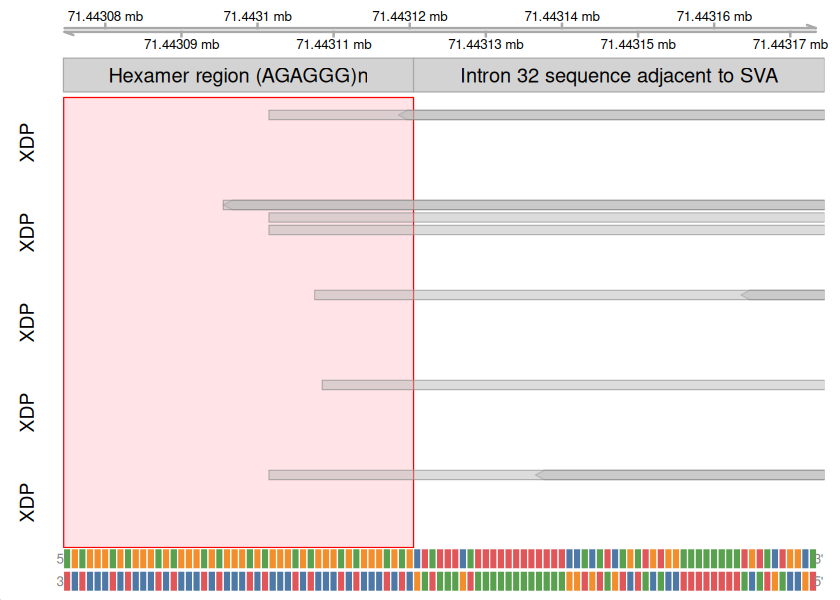

In [15]:
options(ucscChromosomeNames=FALSE)
options(repr.plot.width = 7, repr.plot.height = 5)

annot_track =  AnnotationTrack(start = c(71443075,71443121), end = c(71443120,71443174), strand = c("-", "*"),
                               chromosome = "chrX",
                               id = c("Hexamer region (AGAGGG)n", "Intron 32 sequence adjacent to SVA"),
                               name = "",
                               fill = "lightgrey")

al_2N = AlignmentsTrack(range = c("2N_filtered.bam"), name = "XDP", min.height = 0, max.height = 10,
                                         isPaired = T,
                                         type = "pileup",
                                         showMismatches = F)

al_14N = AlignmentsTrack(range = c("14N_filtered.bam"), name = "XDP", min.height = 0, max.height = 10,
                                         isPaired = T,
                                         type = "pileup",
                                         showMismatches = F)

al_21N = AlignmentsTrack(range = c("21N_filtered.bam"), name = "XDP", min.height = 0, max.height = 10,
                                         isPaired = T,
                                         type = "pileup",
                                         showMismatches = F)

al_33N = AlignmentsTrack(range = c("33N_filtered.bam"), name = "XDP", min.height = 0, max.height = 10,
                                         isPaired = T,
                                         type = "pileup",
                                         showMismatches = F)

al_39N = AlignmentsTrack(range = c("39N_filtered.bam"), name = "XDP", min.height = 0, max.height = 10,
                                         isPaired = T,
                                         type = "pileup",
                                         showMismatches = F)

highlights = HighlightTrack(trackList = list(al_2N, al_14N, al_21N, al_33N, al_39N),
                            start = 71443075, end = 71443120,
                            chromosome = "chrX")

seqTrack53 = SequenceTrack(sequence = xdp$genome,
                           chromosome = "chrX",
                           name = "chrX",
                           fontcolor = c(A="#59A14F",
                                         C="#4E79A7",
                                         T="#E15759",
                                         G="#F28E2B"),
                           add53 = T)

seqTrack35 = SequenceTrack(sequence = xdp$genome,
                           chromosome = "chrX",
                           name = "chrX",
                           fontcolor = c(A="#59A14F",
                                         C="#4E79A7",
                                         T="#E15759",
                                         G="#F28E2B"),
                           add53 = T,
                           complement = T)

genome_axis = GenomeAxisTrack(
                              # col = "black",
                              fontcolor = "black"
                             )

mytracks = list(genome_axis,
                annot_track,
                highlights,
                seqTrack53,
                seqTrack35)


plotTracks(trackList = mytracks,
           # fontface = "bold",
           fontcolor.title = "black",
           fontface.title = "plain",
           # col.border.title = "black",
           fontcolor.feature = "black",
           shape = "box", featureAnnotation = "id",
           background.title = "white",
           sizes=c(.5,.5,1,1,1,1,1,.25,.25),
           from = 71443074,
           to = 71443175)

In [16]:
svg(filename = "reads_plus_strand_xdp_sva.svg", width = 6.5, height = 6)
plotTracks(trackList = mytracks,
           # fontface = "bold",
           fontcolor.title = "black",
           fontface.title = "plain",
           # col.border.title = "black",
           fontcolor.feature = "black",
           shape = "box", featureAnnotation = "id",
           background.title = "white",
           sizes=c(.5,.5,1,1,1,1,1,.25,.25),
           from = 71443074,
           to = 71443175)
dev.off()

pdf(file = "reads_plus_strand_xdp_sva.pdf", width = 6.5, height = 6)
plotTracks(trackList = mytracks,
           # fontface = "bold",
           fontcolor.title = "black",
           fontface.title = "plain",
           # col.border.title = "black",
           fontcolor.feature = "black",
           shape = "box", featureAnnotation = "id",
           background.title = "white",
           sizes=c(.5,.5,1,1,1,1,1,.25,.25),
           from = 71443074,
           to = 71443175)
dev.off()

png 
  2

png 
  2

# Session Info

In [17]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Arch Linux

Matrix products: default
BLAS:   /usr/lib/libopenblas.so.0.3
LAPACK: /usr/lib/liblapack.so.3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] jsonlite_1.8.4       plyranges_1.18.0     BSgenome_1.66.3     
 [4] rtracklayer_1.58.0   Biostrings_2.66.0    XVector_0.38.0      
 [7] Gviz_1.42.1          GenomicRanges_1.50.2 GenomeInfoDb_1.34.9 
[10] IRanges_2.32.0       S4Vectors_0.36.2     BiocGenerics_0.44.0 
[13] ggthemes_4.2.4    